In [64]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [65]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    
    def set_state(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):

        self.ϕ = ϕ  # car initial steering angle
        
        self.θ0 = θ0 
        self.θ1 = θ1 
        self.x = x 
        self.y = y 

        # Draw, if display is True
        if self.display: self.draw()
    
    
    def reset(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = θ0 if θ0 else random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = θ1 if θ1 else (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = x if x else (random() * .75 + 0.25) * self.box[1]
        self.y = y if y else (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
#             print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [4]:
truck = Truck()

In [5]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

<IPython.core.display.Javascript object>


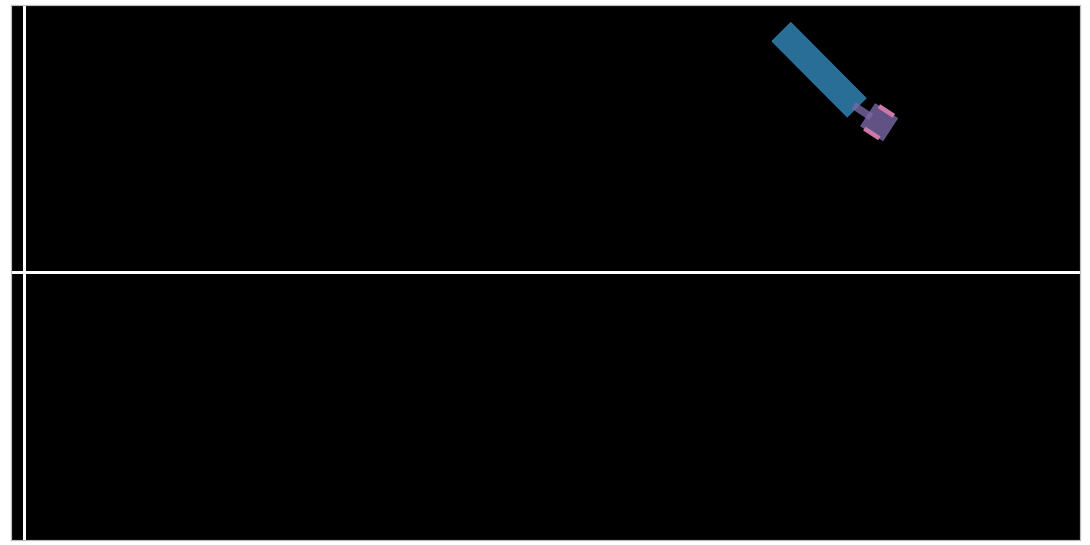

In [73]:
truck = Truck(display=True)
truck.reset()

In [ ]:
# load the model 
path = "truck_model_100.pth"
truck_model.load_state_dict(torch.load(path))

In [1089]:
# run the sequence to watch the truck park itself
truck.reset()
controller.eval()
emulator.eval()
truck.set_state(9+random(),  -8 + random() * 16, deg2rad(-3- + random() * 60), deg2rad(-30 + random() * 60))



def get_sequence(ϕ=None):

    ϕ = ϕ if ϕ is not None else truck.state()
    ϕ = torch.tensor(ϕ)
    target = torch.tensor([0.,0.,0.]).to(device)
    with torch.no_grad():
        controls, states = truck_model(torch.tensor(ϕ).to(device))
    steps = len(controls)
    print(states)
#     distance_to_goal = truck_model.criterion(ϕ[2:5], target).item()
#     if step_count % 10 == 0: print(distance_to_goal)
    step_distance = 1
    return controls, states

truck_model.eval()

step_count = 0 
sequence_count = 0
sequence_theshold = 10

if truck.valid():
    controls, states = get_sequence()
else:
     print ("invalid start")

while truck.valid():
    steering_angle = controls[step_count].clone().detach().cpu().item()
    print(steering_angle)
    ϕ = truck.step(steering_angle)
    truck.draw()
    step_count += 1
    sequence_count +=1

    if sequence_count > sequence_theshold * len(sequence):
        sequence, step_distance = get_sequence(ϕ)
        step_count = 0
        sequence_count = 0

print(f"actual final state: {truck.state()}")






# def get_control(ϕ=None):

#     ϕ = ϕ if ϕ is not None else truck.state()
#     print(ϕ[:6])
#     ϕ = torch.tensor(ϕ).to(device)
#     target = torch.tensor([0.,0.,0.]).to(device)
#     with torch.no_grad():
#         control = controller(ϕ)
#         next_predicted_φ_state = emulator(torch.cat([control, ϕ]))
# #         print(f"predicted state {next_predicted_φ_state}")
#     distance_to_goal = criterion(next_predicted_φ_state[2:5], target).item()
#     print(f"{distance_to_goal} remaining")
                                            
#     return control



# ϕ = None
# step_count = 0 
# sequence_count = 0
# sequence_theshold =  1
# step_distance = 1/10
# control = get_control(ϕ)


# while truck.valid():
#     steering_angle = control.item()
#     ϕ = truck.step(steering_angle, step_distance)

#     truck.draw()
#     step_count += 1
#     sequence_count +=1

#     if sequence_count > sequence_theshold:
#         # get a new sequence of moves based on our current positon
#         control = get_control(ϕ)
#         sequence_count = 0

print(f"actual final state: {truck.state()} in {step_count} steps")

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


tensor([[ 1.4887e-01, -1.5910e-01, -1.0246e-01, -4.1828e-01, -4.8400e-01,
         -9.8692e-01],
        [-7.0907e-02,  1.0488e-01, -1.8076e-01,  1.2434e-04,  1.9440e-02,
          7.4119e-02],
        [-6.7700e-02, -1.1984e-02, -5.8459e-02,  1.0203e-03, -4.4135e-02,
         -1.6955e-02],
        ...,
        [-5.8152e-02, -2.9009e-03, -5.4752e-02, -3.9486e-05, -5.3593e-02,
         -3.2504e-04],
        [-2.3598e-02,  1.6009e-02, -5.7348e-02, -4.4239e-04, -2.3852e-02,
          1.9150e-04],
        [-5.1542e-02,  1.5205e-03, -5.3913e-02, -3.1652e-04, -4.8577e-02,
          7.9951e-04]], device='cuda:0')
-0.009111756458878517
-0.050415389239788055
0.0007428347016684711
-0.20759356021881104
0.17384523153305054
-0.1705380529165268
-0.03599349781870842
0.04448450729250908
-0.09744027256965637
0.15659356117248535
0.07295359671115875
0.15557096898555756
-0.2364071011543274
-0.02677903138101101
0.11371120065450668
0.07988834381103516
-0.23399339616298676
0.055106837302446365
-0.128451883792

In [74]:
print(truck.state())
print(truck.is_jackknifed())



(31.146542299459252, 6.1607508286186174, 5.705657563827013, 28.326189111012486, 8.997228907578183, 5.494936635065013)
False


In [6]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [7]:
truck = Truck();

In [76]:
# Build expert data set

# episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 10000/10000 [00:16<00:00, 593.08it/s]


In [95]:
len(inputs), len(outputs)

(598416, 598416)

In [77]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

emulator = emulator.to(device)

In [78]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [182]:
tensor_inputs = torch.load('tensor_inputs.pt')
tensor_outputs = torch.load('tensor_outputs.pt')

In [15]:
# torch.save(tensor_inputs, 'tensor_inputs.pt')
# torch.save(tensor_outputs, 'tensor_outputs.pt')

In [79]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [80]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

609833 487866


In [81]:
# train_inputs = torch.load('train_inputs.pt')
# train_outputs = torch.load('train_outputs.pt')
# test_inputs = torch.load('test_inputs.pt')
# test_outputs = torch.load('test_outputs.pt')


# torch.save(train_inputs, 'train_inputs.pt')
# torch.save(train_outputs, 'train_outputs.pt')
# torch.save(test_inputs, 'test_inputs.pt')
# torch.save(test_outputs, 'test_outputs.pt')

# train_inputs = Variable(train_inputs.to(device), requires_grad=True) # add gradients so that we can backprop
# train_outputs = Variable(train_outputs.to(device), requires_grad=True)

train_inputs = train_inputs.to(device)
train_outputs = train_outputs.to(device)
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

In [82]:
len(train_inputs)

487866

In [83]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?


cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 487866, 1.9189869165
1000 / 487866, 0.1046412066
2000 / 487866, 0.0291699748
3000 / 487866, 0.0185969789
4000 / 487866, 0.0206762124
5000 / 487866, 0.0107163712
6000 / 487866, 0.0085765896
7000 / 487866, 0.0309939831
8000 / 487866, 0.0296340045
9000 / 487866, 0.0074120858
10000 / 487866, 0.0043150405
11000 / 487866, 0.0091394288
12000 / 487866, 0.0095119961
13000 / 487866, 0.0164935738
14000 / 487866, 0.0195971765
15000 / 487866, 0.0023762344
16000 / 487866, 0.0022691519
17000 / 487866, 0.0175016448
18000 / 487866, 0.0020279810
19000 / 487866, 0.0020351408
20000 / 487866, 0.0047998377
21000 / 487866, 0.0010603111
22000 / 487866, 0.0019715598
23000 / 487866, 0.0011329530
24000 / 487866, 0.0044500246
25000 / 487866, 0.0014829222
26000 / 487866, 0.0064623631
27000 / 487866, 0.0082889237
28000 / 487866, 0.0005289050
29000 / 487866, 0.0029300002
30000 / 487866, 0.0016334271
31000 / 487866, 0.0044028950
32000 / 487866, 0.0062261405
33000 / 487866, 0.0016019018
34000 / 487866, 0.003899

277000 / 487866, 0.0001592159
278000 / 487866, 0.0008160598
279000 / 487866, 0.0004551532
280000 / 487866, 0.0002146543
281000 / 487866, 0.0000390433
282000 / 487866, 0.0001123117
283000 / 487866, 0.0000784528
284000 / 487866, 0.0006483194
285000 / 487866, 0.0001756745
286000 / 487866, 0.0002306773
287000 / 487866, 0.0000966100
288000 / 487866, 0.0000858375
289000 / 487866, 0.0001477391
290000 / 487866, 0.0001175530
291000 / 487866, 0.0005418852
292000 / 487866, 0.0003630506
293000 / 487866, 0.0000515154
294000 / 487866, 0.0008538153
295000 / 487866, 0.0004609176
296000 / 487866, 0.0000069588
297000 / 487866, 0.0002539175
298000 / 487866, 0.0001056325
299000 / 487866, 0.0004016358
300000 / 487866, 0.0000882415
301000 / 487866, 0.0001851793
302000 / 487866, 0.0002760347
303000 / 487866, 0.0002685354
304000 / 487866, 0.0001923317
305000 / 487866, 0.0002741308
306000 / 487866, 0.0002120979
307000 / 487866, 0.0005276941
308000 / 487866, 0.0001233149
309000 / 487866, 0.0004365543
310000 / 4

In [189]:
# load the emulator model
path = "emulator-model.pth"
emulator.load_state_dict(torch.load(path))
emulator.eval()

Sequential(
  (0): Linear(in_features=7, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=6, bias=True)
)

In [62]:
# path = "emulator-new.pth"
# torch.save(emulator.state_dict(), path)

In [101]:
# Test

emulator.eval()
emulator_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)
        
        next_state = test_outputs[idx]
        emulator_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [102]:
print(f'Test loss: {emulator_validation_loss:.10f}')

Test loss: 14.6103903395


In [86]:
state_size = 6
steering_size = 1
hidden_units_c = 25



controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size),
    HalfPiSigmoid()
)

optimiser_c = SGD(emulator.parameters(), lr=0.005)
criterion_c = nn.MSELoss()

controller = controller.to(device)

In [87]:
# pretrain the controller layer with the training dataset

emulator.eval()
controller.train()

cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_control_prediction = controller(ϕ_state[1:])

    next_state_prediction = emulator(torch.cat([next_control_prediction, ϕ_state[1:]]))

    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_c.zero_grad()
    loss.backward()
    optimiser_c.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 487866, 0.0000428616
1000 / 487866, 0.0000493441
2000 / 487866, 0.0001949111
3000 / 487866, 0.0000862607
4000 / 487866, 0.0001680623
5000 / 487866, 0.0000837393
6000 / 487866, 0.0001493383
7000 / 487866, 0.0002422032
8000 / 487866, 0.0000197708
9000 / 487866, 0.0000602679
10000 / 487866, 0.0000316796
11000 / 487866, 0.0003539423
12000 / 487866, 0.0000205749
13000 / 487866, 0.0002376625
14000 / 487866, 0.0003024637
15000 / 487866, 0.0002732314
16000 / 487866, 0.0000779057
17000 / 487866, 0.0003671799
18000 / 487866, 0.0000907309
19000 / 487866, 0.0000456687
20000 / 487866, 0.0000548587
21000 / 487866, 0.0000656348
22000 / 487866, 0.0000576065
23000 / 487866, 0.0005138271
24000 / 487866, 0.0002082233
25000 / 487866, 0.0002523294
26000 / 487866, 0.0000107314
27000 / 487866, 0.0000342513
28000 / 487866, 0.0002281813
29000 / 487866, 0.0004767622
30000 / 487866, 0.0002357298
31000 / 487866, 0.0002514739
32000 / 487866, 0.0001685876
33000 / 487866, 0.0000819163
34000 / 487866, 0.000004

277000 / 487866, 0.0002630379
278000 / 487866, 0.0000763305
279000 / 487866, 0.0001875821
280000 / 487866, 0.0000495244
281000 / 487866, 0.0000381587
282000 / 487866, 0.0002719759
283000 / 487866, 0.0000479804
284000 / 487866, 0.0002031781
285000 / 487866, 0.0000579575
286000 / 487866, 0.0003208586
287000 / 487866, 0.0005372683
288000 / 487866, 0.0001161138
289000 / 487866, 0.0000363817
290000 / 487866, 0.0000726798
291000 / 487866, 0.0000386531
292000 / 487866, 0.0000622108
293000 / 487866, 0.0000740916
294000 / 487866, 0.0004294135
295000 / 487866, 0.0004115354
296000 / 487866, 0.0002177172
297000 / 487866, 0.0003897280
298000 / 487866, 0.0000769710
299000 / 487866, 0.0001079700
300000 / 487866, 0.0000571086
301000 / 487866, 0.0000216738
302000 / 487866, 0.0000445837
303000 / 487866, 0.0001282240
304000 / 487866, 0.0000449891
305000 / 487866, 0.0002259009
306000 / 487866, 0.0001574369
307000 / 487866, 0.0000109908
308000 / 487866, 0.0002640557
309000 / 487866, 0.0004484575
310000 / 4

In [104]:
# Test
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

controller.eval()
controller_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(torch.cat([next_control_prediction, ϕ_state[1:]]))

        next_state = test_outputs[idx]
        controller_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [105]:
print(f'Test loss: {controller_validation_loss:.10f}')

Test loss: 30.8114325052


In [190]:
path = "controller-new.pth"
controller.load_state_dict(torch.load(path))
controller.eval()

Sequential(
  (0): Linear(in_features=6, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=1, bias=True)
  (3): HalfPiSigmoid()
)

In [89]:
# # save the pretrained controller model
# path = "controller-new.pth"
# torch.save(controller.state_dict(), path)

In [68]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR



class HalfPiSigmoid(nn.Module):
    """Returns Sigmoid with the range -pi/2 to pi/2 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * pi


class ControllerLayer(nn.Module):
    def __init__(self, input_size=6, n_hidden=25, output_size=1):
        super(ControllerLayer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            HalfPiSigmoid()
        )
        self.control = []
    def forward(self, x):
        #x = x.view(-1, self.input_size)
        return self.network(x)
    
    
class TruckBackerUpper(nn.Module):
    def __init__(self, input_size=1, n_feature=6, output_size=1, n_layers=400, 
                 lr=0.1, momentum=0.9, docking_threshold=2, docking_goal=0.25, allowed_moves_before_docked=5):
        super(TruckBackerUpper, self).__init__()
        self.n_feature = n_feature
        self.n_layers = n_layers
        self.emulator = emulator
        self.control_layers = []
        self.lr = lr
        self.momentum = momentum
        for i in range(self.n_layers):
            self.control_layers.append(ControllerLayer())
        self.layers = nn.ModuleList(self.control_layers)
        self.steering_control = []
        self.optimizer = SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.criterion = nn.MSELoss()
        self.docking_threshold = docking_threshold
        self.docking_goal = docking_goal
        self.allowed_moves_before_docked = allowed_moves_before_docked
    
    def is_jackknifed(self, current_state):
        θ0 = current_state[2].item()
        θ1 = current_state[5].item()
        return abs(θ0 - θ1) * 180 / pi > 90

    def is_stalled(self, state, next_state):
        return self.criterion(state, next_state) < 0.00001

    def is_moving_wrong_way(self, current_state, start_state, target):
        return self.criterion(current_state[3:], target) - self.criterion(start_state[3:], target) > 20

    def is_driving_in_circles(self, steps):
        return steps > 2_000

    def is_offscreen(self, next_state):
        W = 1  # car and trailer width, for drawing only
        L = 1 * W  # car length
        d = 4 * L  # d_1

        x, y, θ0, x2, y2, θ1 = next_state.detach()
        x, y, θ0, x2, y2, θ1 = x.to(device), y.to(device), θ0.to(device), x2.to(device), y2.to(device), θ1.to(device)

        x1, y1 = x + 1.5 * L * cos(θ0.cpu()), y + 1.5 * L * sin(θ0.cpu())

        b = [0, 40, -10, 10] # screen size
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )

    def is_docked(self, this_state, last_state, target, moves_inside_dock):
        last_loss = self.criterion(last_state[3:], target)
        this_loss = self.criterion(this_state[3:], target)
        within_dock_threshold = this_loss < self.docking_threshold
        moving_toward_dock = this_loss < last_loss
        if within_dock_threshold and not moving_toward_dock:
            moves_inside_dock += 1
            if moves_inside_dock > self.allowed_moves_before_docked:
                return True, moves_inside_dock, this_loss
            if this_loss < self.docking_goal:
                return True, moves_inside_dock, this_loss
        else:
            moves_inside_dock = 0
        return False, moves_inside_dock, this_loss
    
    def freeze_model(self):
        self.eval()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = False
            
    def unfreeze_model(self):
        self.train()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = True
        
    def forward(self, x, verbose=False):
        state = x
        steering_controls = []
        states = []
        for i, l in enumerate(self.control_layers):
            steering_amount = self.control_layers[i](state) 
            steering_controls.append(steering_amount)
            state = emulator(torch.cat([steering_amount, state]))
            states.append(state)
        control_sequence = torch.stack(steering_controls).view(-1, 1)
        states = torch.stack(states).view(-1, 6)
        
        return control_sequence, states

In [75]:
n_layers = 200 # per the paper should be 4 * number of steps per sequence
truck_model = TruckBackerUpper(n_layers=n_layers, lr=0.005, docking_goal=2, docking_threshold=15)

#truck_model = TruckBackerUpper(n_layers=n_layers, lr=0.9, momentum=0.9, docking_goal=5)
truck_model = truck_model.to(device)

truck_model.train()

TruckBackerUpper(
  (emulator): Sequential(
    (0): Linear(in_features=7, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=6, bias=True)
  )
  (layers): ModuleList(
    (0): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (1): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (2): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (3): ControllerLayer(
      (network): Sequential(
       

In [70]:
# # test whether pre-trained truck_model can predcit the test set
# controller.train()
# truck_model.eval()


# truck_model_validation_loss = 0
# with torch.no_grad():
#     for idx, ϕ_state in enumerate(test_inputs):
#         next_state_prediction = truck_model(ϕ_state.to(device)[1:])[1][0]

#         next_state = test_outputs[idx].to(device)
#         truck_model_validation_loss += criterion(next_state_prediction, next_state).item()


In [71]:
# print(f'Test loss: {truck_model_validation_loss:.10f}')

In [ ]:
# # training code truck with new strategy
# truck = Truck()
# truck_model.train()
# emulator.eval()

# target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
# cnt = 0

# running_loss = 0
# last_running_loss = inf
# running_step_count = 0
# steps = 0
# batch_steps = 0
# early_stop_threshold = 5
# successful_runs = 0
# jackknifes = 0


# iterations = 10_000
# # iterations = len(train_inputs)

# for epoch in range(5):
#     for i in torch.randperm(len(train_outputs)):
# #     for i in range(5000,5001):

# #     for i in range(5000,5001):


        
#         batch_steps += steps
#         steps = 0
#         emulator_steps = 0
#         truck_steps = 0

#         stop_conditions = False
#         truck.reset()
        
#         x = 8 + random()
#         y = -8 + random() * 16
#         θ0 = deg2rad(-15 + random() * 30)
#         θ1 = deg2rad(-15 + random() * 30) 
        
#         truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )
# #         print(truck.state())

#         ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)


    
#         if not truck.valid():
#             print ("invalid start")
#             continue

            
      
#         start_state = f"({truck.state()[3]:.2f},{truck.state()[4]:.2f},{truck.state()[5]:.2f})"
 

#         sum_loss = 0
#         moves_inside_dock = 0 
#         step_distance = 1

                            
#         # get the prediction
#         predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
# #         print(predicted_steering_controls)
# #         print(predicted_ϕ_states)
# #         break
        
#         number_of_predicted_steps = len(predicted_ϕ_states)
#         step_distance =  1
# #         step_distance = 1

#         # next we'll compare the emulated postion to the actual position of our truck
        
#         loss_truck = 0
#         loss_actual = 0

#         best_loss = inf
        
# #         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
# #         truck.set_state(x, y, θ0, θ1)
# # #         truck.draw()
        

#         stop_conditions = False
#         docked = False
                            
        
#         while truck.valid() and (steps < number_of_predicted_steps):
#             x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()
#             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    
#             predicted_steering_control = predicted_steering_controls[steps]
#             control = predicted_steering_control.clone().detach().cpu().item()
# #             print(f"truck state {truck_ϕ_state}")
# #             print(f"predicted control {predicted_steering_control}")
#             next_truck_ϕ_state = truck.step(control)
# #             print(f"next truck state {next_truck_ϕ_state}")
#             if truck.valid():
#                 steps += 1
#                 ϕ_state = predicted_ϕ_states[steps]
# #                 print(f"emulated state {ϕ_state} ")
#                 loss_truck += truck_model.criterion(ϕ_state[3:4], target[0:1]) / steps  # make it to the target
#                 loss_truck += truck_model.criterion(θ0, θ1) / (1 / steps) # don't jackknife
                
# #             
#         loss_truck +=  truck_model.criterion(ϕ_state[3:4], target[0:1])  / (steps) # make it to the target
#         loss_truck +=  truck_model.criterion(torch.tensor(next_truck_ϕ_state).to(device), target[0:1])  / (steps) # make it to the target
#         loss_truck += truck_model.criterion(ϕ_state[5], target[2]) /steps
#         loss_truck += truck_model.criterion(θ0, θ1) ** 4
        
# #         if truck.is_jackknifed():
# #             print(f"jackknife loss {criterion_c(θ0, θ1)}")
 
# #         k_state = initial_ϕ_state
# #         x, y, θ0, x2, y2, θ1 = k_state.clone().detach()
# #         x, y, θ0, x2, y2, θ1 = x.item(), y.item(), θ0.item(), x2.item(), y2.item(), θ1.item()
# # #         print(f"x {x}, y {y}, θ0 {θ0}, x2 {x2}, y2 {y2}, θ1 {θ1}")
# #         truck.set_state(x, y, θ0, θ1)
# # #         print(f"truck state: {truck.state()}")
# # #         print(f"k_state: {k_state}")
        
# #         while truck.valid():
# #             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
# #             next_truck_ϕ_state = truck.step(control)
# #             if truck.valid:
# #                 k_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))



            
    
#         actual_final_state = f"({next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
#         predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"

        

                 
        
#         jackknifed = truck.is_jackknifed()
#         offscreen = truck.is_offscreen()
                            
# #         while truck.valid() and (steps < number_of_predicted_steps):
# #             steering_angle = predicted_steering_controls[steps].item()

# #             next_predicted_ϕ_state = predicted_ϕ_states[steps]
# #             next_actual_ϕ_state = torch.tensor(truck.step(steering_angle, step_distance)).to(device)

# #             loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) # loss for not moving to the correct state
# # #             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

# #             actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
# #             predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
# #             jackknifed = truck.is_jackknifed()
# #             offscreen = truck.is_offscreen()

# #             steps += 1
        
# #         loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # loss for not reaching goal
            
# #         if docked and not jackknifed:
# #             successful_runs += 1

#         if jackknifed:
#             jackknifes += 1

     
#         truck_model.zero_grad()
#         emulator.zero_grad()
#         loss_truck.backward()



#         truck_model.optimizer.step()
        
#         final_loss = loss_truck.item()

#         running_loss += final_loss
#         running_step_count += steps

#         display_threshold = 100

#         if cnt == 0 or (cnt + 1) % display_threshold == 0:
#             print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
#         cnt += 1

#         summary_threshold = 500

#         if (cnt + 1) % summary_threshold == 0:
#             print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


#             if running_loss > last_running_loss:
#                 early_stop_count += 1
#             else:
#                 early_stop_count = 0

#             print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



#             if early_stop_count > early_stop_threshold:
#                 break

#             last_running_loss = running_loss
#             running_loss = 0
#             running_step_count = 0
#             successful_runs = 0
#             jackknifes = 0
    

In [192]:
# training code using just the controller and emulator
truck = Truck()
emulator.eval()
controller.train()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0
start_x = 4
start_y = -3


iterations = 10_000
# iterations = len(train_inputs)

for epoch in range(5):
    for i in torch.randperm(len(train_outputs)):
#     for i in range(5000,5001):
        

        batch_steps += steps
        steps = 0
        emulator_steps = 0
        truck_steps = 0

        stop_conditions = False
        x = start_x + random()
        y = start_y + random() * start_y * -2
        θ0 = deg2rad(-15 + random() * 30)
        θ1 = deg2rad(-15 + random() * 30) 
        
        truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )
#         print(truck.state())

#         ϕ_state = train_inputs[i][1:]
        ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
        initial_ϕ_state = ϕ_state.clone()
    
        if not truck.valid():
            print ("invalid start")
            continue


        start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
        last_ϕ_state = ϕ_state
        last_actual_ϕ_state = ϕ_state

        sum_loss = 0
        moves_inside_dock = 0 
        step_distance = 0.25

   

        # next we'll compare the emulated postion to the actual position of our truck
        
        loss_truck = 0
        loss_actual = 0

        best_loss = inf
        
#         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
#         truck.set_state(x, y, θ0, θ1)
# #         truck.draw()

        stop_conditions = False
        docked = False
        loss_truck = 0
        
        
        while truck.valid():
            x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()
#             truck.set_state(x, y, θ0, θ1)
#             print(f"truck state {truck.state()}")

#             print(f"control {control}")
#             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    
#             predicted_steering_control = controller(truck_ϕ_state)
            predicted_steering_control = controller(ϕ_state)
            control = predicted_steering_control.clone().detach().cpu().item()
#             print(f"truck state {truck_ϕ_state}")
            print(f"predicted control {control}")
            next_truck_ϕ_state = truck.step(control)
#             print(f"next truck state {next_truck_ϕ_state}")
            steps += 1
            if truck.valid():
                ϕ_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))
#                 print(f"emulated state {ϕ_state} ")
                loss_truck += criterion_c(ϕ_state[3:], target)   # make it to the target
#                 loss_truck += criterion_c(θ0, θ1) ** 4  # don't jackknife
                loss_truck += criterion_c(torch.tensor(next_truck_ϕ_state[3:], requires_grad=True).to(device), target)
                loss_truck /= steps 
#                 print(loss_truck)
        if steps > 1:    
            loss_truck += criterion_c(torch.tensor(next_truck_ϕ_state[3:], requires_grad=True).to(device), target)  #actual position
#             print(loss_truck)
#             loss_truck += criterion_c(θ0, θ1)  ** 2 
#             
#         loss_truck +=  criterion_c(ϕ_state[3:4], target[0:1])  / (steps) # make it to the target
#         loss_truck += criterion_c(θ0, θ1) ** 4
        
#         if truck.is_jackknifed():
#             print(f"jackknife loss {criterion_c(θ0, θ1)}")
 
#         k_state = initial_ϕ_state
#         x, y, θ0, x2, y2, θ1 = k_state.clone().detach()
#         x, y, θ0, x2, y2, θ1 = x.item(), y.item(), θ0.item(), x2.item(), y2.item(), θ1.item()
# #         print(f"x {x}, y {y}, θ0 {θ0}, x2 {x2}, y2 {y2}, θ1 {θ1}")
#         truck.set_state(x, y, θ0, θ1)
# #         print(f"truck state: {truck.state()}")
# #         print(f"k_state: {k_state}")
        
#         while truck.valid():
#             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
#             next_truck_ϕ_state = truck.step(control)
#             if truck.valid:
#                 k_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))



            
    
        actual_final_state = f"({next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
        predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"

        

                 
        
        jackknifed = truck.is_jackknifed()
        offscreen = truck.is_offscreen()

                
                
        
        if loss_truck < 5:
            successful_runs += 1

        if jackknifed:
            jackknifes += 1


        controller.zero_grad()
        emulator.zero_grad()

        if loss_truck == 0:
            print("No Loss")
            continue

        final_loss = loss_truck.item()
        loss_truck.backward()
        
        optimiser_c.step()
        


        running_loss += final_loss
        running_step_count += steps

        display_threshold = 100

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 500

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")
            # scheduler
            if successful_runs > 200 and jackknifes < 200:
                start_x += 1
                print(f"{successful_runs} successful runs. Increasing starting x position to {start_x}")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    

predicted control -0.6346513032913208
predicted control -0.8331658244132996
predicted control -0.8327072262763977
predicted control -0.8327080011367798
predicted control -0.8327080011367798
predicted control -0.8327080011367798
predicted control -0.8327080011367798
predicted control -0.8327080011367798
  1, item loss: 1.129, steps:   8, start state: (0.59,1.56,-0.16), predicted final state: (-0.00,-0.00,-0.00), actual final state: (-0.05,1.68,-0.26), last move: -0.833, docked: False, jackknifed: False, offscreen: True
predicted control -0.5861340165138245
predicted control -0.8333888053894043
predicted control -0.8327067494392395
predicted control -0.8327080607414246
predicted control -0.6543475985527039
predicted control -0.8331025242805481
predicted control -0.8327345848083496
predicted control -0.8327350616455078
predicted control -0.8327350616455078
predicted control -0.8327350616455078
predicted control -0.8327350616455078
predicted control -0.8327350616455078
predicted control -0

predicted control -0.8327328562736511
predicted control -0.8327328562736511
predicted control -0.8327328562736511
predicted control -0.8327328562736511
predicted control -0.5911586880683899
predicted control -0.8333626389503479
predicted control -0.8327205181121826
predicted control -0.8327216506004333
predicted control -0.8327215313911438
predicted control -0.8327215313911438
predicted control -0.8327215313911438
predicted control -0.8327215313911438
predicted control -0.8327215313911438
predicted control -0.8327215313911438
predicted control -0.5835374593734741
predicted control -0.8333869576454163
predicted control -0.8327101469039917
predicted control -0.8327111601829529
predicted control -0.8327111601829529
predicted control -0.8327111601829529
predicted control -0.8327111601829529
predicted control -0.6916472911834717
predicted control -0.8329302668571472
predicted control -0.8326952457427979
predicted control -0.8326955437660217
predicted control -0.8326955437660217
predicted co

predicted control -0.5606472492218018
predicted control -0.8334406018257141
predicted control -0.8326820135116577
predicted control -0.6742355823516846
predicted control -0.8329381942749023
predicted control -0.8326737284660339
predicted control -0.8326741456985474
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.8326743841171265
predicted control -0.5952243804931641
predicted control -0.8332633972167969
predicted control -0.8326652646064758
predicted control -0.8326663970947266
predicted control -0.8326662182807922
predicted control -0.8326662182807922
predicted control -0.8326662182807922
predicted control -0.8326662182807922
predicted control -0.8326662182807922
predicted co

predicted control -0.6947185397148132
predicted control -0.8328484296798706
predicted control -0.8326181173324585
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.8326186537742615
predicted control -0.5962220430374146
predicted control -0.8331851959228516
predicted control -0.8326054811477661
predicted control -0.8326066732406616
predicted control -0.8326066732406616
predicted control -0.8326066732406616
predicted control -0.8326066732406616
predicted control -0.8326066732406616
predicted control -0.6920106410980225
predicted control -0.8328220844268799
predicted control -0.8325871825218201
predicted control -0.8325877785682678
predicted control -0.8325878381729126
predicted control -0.8325878381729126
predicted co

predicted control -0.8327395915985107
predicted control -0.8325827121734619
predicted control -0.8325830698013306
predicted control -0.8325828909873962
predicted control -0.8325830698013306
predicted control -0.8325828909873962
predicted control -0.8325830698013306
predicted control -0.8325828909873962
predicted control -0.8325830698013306
predicted control -0.8325828909873962
predicted control -0.8325830698013306
predicted control -0.6217332482337952
predicted control -0.8330186009407043
predicted control -0.8325749039649963
predicted control -0.8325755596160889
predicted control -0.8325755596160889
predicted control -0.8325755596160889
predicted control -0.8325755596160889
predicted control -0.8325755596160889
predicted control -0.5926288366317749
predicted control -0.8331406116485596
predicted control -0.8325627446174622
predicted control -0.8325638175010681
predicted control -0.8325638175010681
predicted control -0.8325638175010681
predicted control -0.8325638175010681
predicted co

predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.8324632048606873
predicted control -0.613150954246521
predicted control -0.8329269886016846
predicted control -0.8324582576751709
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.8324590921401978
predicted control -0.6921868324279785
predicted control -0.8326894640922546
predicted control -0.8324548006057739
predicted con

predicted control -0.8325780034065247
predicted control -0.5016776323318481
No Loss
predicted control -0.5633977055549622
predicted control -0.8332321643829346
predicted control -0.8325405716896057
predicted control -0.8325417041778564
predicted control -0.5732966065406799
predicted control -0.8331624269485474
predicted control -0.8325169682502747
predicted control -0.8325181007385254
predicted control -0.8325182199478149
predicted control -0.8325182199478149
predicted control -0.8325182199478149
predicted control -0.8325182199478149
predicted control -0.8325182199478149
predicted control -0.8325182199478149
predicted control -0.44431963562965393
predicted control -0.8337460160255432
predicted control -0.8325065970420837
predicted control -0.8325085639953613
predicted control -0.8325085639953613
predicted control -0.8325085639953613
predicted control -0.8325085639953613
predicted control -0.7020016312599182
predicted control -0.832711935043335
predicted control -0.8324935436248779
pred

predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.8324569463729858
predicted control -0.5532841682434082
predicted control -0.8331503868103027
predicted control -0.8324458003044128
predicted control -0.8324471116065979
predicted control -0.8324471116065979
predicted control -0.8324471116065979
predicted control -0.8324471116065979
predicted control -0.4640709459781647
predicted control -0.8335388898849487
predicted control -0.832423746585846
predicted control -0.8324254751205444
predicted control -0.5276400446891785
predicted control -0.8332180380821228
predicted control -0.8323965668678284
predicted control -0.8323980569839478
predicted control -0.8323980569839478
predicted control -0.5563154220581055
predicted control -0.833063006401062
predicted cont

predicted control -0.5694050192832947
predicted control -0.8330680727958679
predicted control -0.8324511647224426
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.8324523568153381
predicted control -0.4915393590927124
predicted control -0.8334107398986816
predicted control -0.832435131072998
predicted control -0.5107788443565369
predicted control -0.833314836025238
predicted control -0.8324285745620728
predicted control -0.8324303030967712
predicted control -0.8324303030967712
predicted control -0.8324303030967712
predicted control -0.537953794002533
predicted control -0.8331575989723206
predicted control -0.8323972225189209
predicted control -0.8323983550071716
predicted control -0.8323984146118164
predicted control -0.8323984146118164
predicted control -0.8323984146118164
predicted contr

predicted control -0.832288920879364
predicted control -0.8322896361351013
predicted control -0.8322896361351013
predicted control -0.8322896361351013
predicted control -0.6199818849563599
predicted control -0.8326473832130432
predicted control -0.8322782516479492
predicted control -0.8322787880897522
predicted control -0.8322787880897522
predicted control -0.8322787880897522
predicted control -0.8322787880897522
predicted control -0.8322787880897522
predicted control -0.5222582221031189
predicted control -0.8330907225608826
predicted control -0.832270622253418
predicted control -0.6034014225006104
predicted control -0.832795262336731
predicted control -0.8323498368263245
predicted control -0.8323509097099304
predicted control -0.8323506712913513
predicted control -0.8323506712913513
predicted control -0.8323506712913513
predicted control -0.8323506712913513
predicted control -0.8323506712913513
predicted control -0.7088233828544617
predicted control -0.8325448632240295
predicted contr

predicted control -0.8322898149490356
predicted control -0.8322896361351013
predicted control -0.8322898149490356
predicted control -0.8322896361351013
predicted control -0.8322898149490356
predicted control -0.8322896361351013
predicted control -0.8322898149490356
predicted control -0.8322896361351013
predicted control -0.8322898149490356
predicted control -0.5469133853912354
predicted control -0.832979679107666
predicted control -0.8322806358337402
predicted control -0.8322819471359253
predicted control -0.8322819471359253
predicted control -0.8322819471359253
predicted control -0.8322819471359253
predicted control -0.8322819471359253
predicted control -0.620711624622345
predicted control -0.8326268196105957
predicted control -0.8322687745094299
predicted control -0.8322694301605225
predicted control -0.8322694301605225
predicted control -0.8322694301605225
predicted control -0.8322694301605225
predicted control -0.719833254814148
predicted control -0.8324443101882935
predicted contr

predicted control -0.44898009300231934
predicted control -0.8334674835205078
predicted control -0.6130887866020203
predicted control -0.8327788710594177
predicted control -0.8324040770530701
predicted control -0.8324047923088074
predicted control -0.8324047923088074
predicted control -0.8324047923088074
predicted control -0.8324047923088074
predicted control -0.8324047923088074
predicted control -0.56379234790802
predicted control -0.8329682350158691
predicted control -0.8323665857315063
predicted control -0.8323677182197571
predicted control -0.6239718794822693
predicted control -0.832634449005127
predicted control -0.8322843909263611
predicted control -0.8322849869728088
predicted control -0.8322849869728088
predicted control -0.8322849869728088
predicted control -0.7365954518318176
predicted control -0.8324087262153625
predicted control -0.8322479128837585
predicted control -0.8322480916976929
predicted control -0.8322480916976929
predicted control -0.8322480916976929
predicted cont

predicted control -0.8322105407714844
predicted control -0.8322104215621948
predicted control -0.8322105407714844
predicted control -0.8322104215621948
predicted control -0.8322105407714844
predicted control -0.616805911064148
predicted control -0.832563042640686
predicted control -0.8322008848190308
predicted control -0.8322014808654785
predicted control -0.8322014808654785
predicted control -0.8322014808654785
predicted control -0.8322014808654785
predicted control -0.8322014808654785
predicted control -0.7051050066947937
predicted control -0.8324034214019775
predicted control -0.832189679145813
predicted control -0.8321900367736816
predicted control -0.8321899175643921
predicted control -0.8321900367736816
predicted control -0.8321899175643921
predicted control -0.8321900367736816
predicted control -0.8321899175643921
predicted control -0.8321900367736816
predicted control -0.8321899175643921
predicted control -0.7081648111343384
predicted control -0.8323914408683777
predicted contr

predicted control -0.49523669481277466
predicted control -0.8330991268157959
predicted control -0.4921411871910095
predicted control -0.8332687020301819
predicted control -0.6802950501441956
predicted control -0.8326697945594788
predicted control -0.8324139714241028
predicted control -0.8324143886566162
predicted control -0.8324145674705505
predicted control -0.8324145674705505
predicted control -0.8324145674705505
predicted control -0.8324145674705505
predicted control -0.8324145674705505
predicted control -0.8324145674705505
predicted control -0.533997118473053
predicted control -0.8331038355827332
predicted control -0.8323827385902405
predicted control -0.8323840498924255
predicted control -0.8323840498924255
predicted control -0.8323840498924255
predicted control -0.8323840498924255
predicted control -0.8323840498924255
predicted control -0.6375986933708191
predicted control -0.8326725959777832
predicted control -0.8323450684547424
predicted control -0.8323456645011902
predicted co

predicted control -0.7335621118545532
predicted control -0.8323320746421814
predicted control -0.8321660757064819
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.8321662545204163
predicted control -0.6861776113510132
predicted control -0.8324001431465149
predicted control -0.8321544528007507
predicted control -0.8321547508239746
predicted control -0.8321546316146851
predicted control -0.8321546316146851
predicted control -0.8321546316146851
predicted control -0.8321546316146851
predicted control -0.7449125647544861
predicted control -0.8322868347167969
predicted control -0.8321398496627808
predicted control -0.8321402072906494
predicted control -0.8321402072906494
predicted control -0.8321402072906494
predicted control -0.8321402072906494
predicted control -0.8321402072906494
predicted co

predicted control -0.8319586515426636
predicted control -0.8320594429969788
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.8320592045783997
predicted control -0.930406928062439
predicted control -0.8318907022476196
predicted control -0.8320566415786743
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.8320563435554504
predicted control -0.8320564031600952
predicted control -0.6943536400794983
predicted con

predicted control -0.8688050508499146
predicted control -0.8319731950759888
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.8320350646972656
predicted control -0.9535631537437439
predicted control -0.8318297266960144
predicted control -0.8320345878601074
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8320342302322388
predicted control -0.8944123387336731
predicted co

predicted control -0.6840081810951233
predicted control -0.832276463508606
predicted control -0.8320271372795105
predicted control -0.8320274949073792
predicted control -0.8320274949073792
predicted control -0.8320274949073792
predicted control -0.8320274949073792
predicted control -0.8320274949073792
predicted control -0.8320274949073792
predicted control -0.8106446266174316
predicted control -0.8320630788803101
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted con

predicted control -0.8320260643959045
predicted control -0.8320260643959045
predicted control -0.8320260643959045
predicted control -0.7805275321006775
predicted control -0.8321126699447632
predicted control -0.8320260047912598
predicted control -0.8320260643959045
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8320261836051941
predicted control -0.8127741813659668
predicted control -0.8320587873458862
predicted control -0.8320260047912598
predicted control -0.8320261836051941
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8320263028144836
predicted control -0.8355596661567688
predicted co

predicted control -0.8321308493614197
predicted control -0.8320269584655762
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.7279128432273865
predicted control -0.8322023749351501
predicted control -0.8320269584655762
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.8320271372795105
predicted control -0.6392391324043274
predicted control -0.8323514461517334
predicted co

predicted control -0.7815208435058594
predicted control -0.8321132659912109
predicted control -0.8320280313491821
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.9447236061096191
predicted control -0.831838846206665
predicted control -0.8320288062095642
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted control -0.8320284485816956
predicted con

predicted control -0.8320295810699463
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.8320292830467224
predicted control -0.6439459323883057
predicted control -0.8323459029197693
predicted control -0.8320289850234985
predicted control -0.8320295810699463
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted control -0.8320293426513672
predicted co

predicted control -0.8433593511581421
predicted control -0.832010805606842
predicted control -0.8320299983024597
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted control -0.7209792137145996
predicted control -0.8322167992591858
predicted control -0.8320295810699463
predicted control -0.8320298194885254
predicted control -0.8320298194885254
predicted control -0.8320298194885254
predicted control -0.8320298194885254
predicted control -0.8320298194885254
predicted control -0.8320298194885254
predicted control -0.767382800579071
predicted control -0.83213871717453
predicted control -0.8320298194885254
predicted control -0.8320299386978149
predicted control -0.8320299386978149
predicted contro

predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8541621565818787
predicted control -0.8319931626319885
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.8320304155349731
predicted control -0.6515499353408813
predicted control -0.8323342204093933
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8581644296646118
predicted control -0.8319867849349976
predicted control -0.8320310711860657
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8009552359580994
predicted co

predicted control -0.7986178994178772
predicted control -0.8320870399475098
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.8320308923721313
predicted control -0.7996509671211243
predicted control -0.832085371017456
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8583962321281433
predicted control -0.831986665725708
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
700, item loss: 0.106, steps:  16, start state: (1.54,0.55,0.21), predicted final state: (-0.00,-0.00,-0.00), actual final state: (0.43,0.34,0.02), last move: -0.832, docked: False, jackknifed: True, offscreen: False
predicted control -0.8755877017974854
predicted control -0.8319574594497681
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.832

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9016774892807007
predicted control -0.8319138288497925
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.812477171421051
predicted control -0.8320640325546265
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8318668603897095
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8783749938011169
predicted control -0.8319528698921204
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8322364687919617
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8297864198684692
predicted control -0.8320350050926208
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6618300676345825
predicted control -0.8323172926902771
predicted co

predicted control -0.739826500415802
predicted control -0.8321861028671265
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.687825620174408
predicted control -0.832273542881012
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted contr

predicted control -0.6416334509849548
predicted control -0.8323512673377991
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.856071412563324
predicted control -0.8319905996322632
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8881453275680542
predicted control -0.8319366574287415
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
800, item loss: 0.219, steps:  13, start state: (1.64,0.09,0.13), predicted final state: (-0.00,-0.00,-0.00), actual final state: (0.77,0.01,-0.06), last move: -0.832, docked: False, jackknifed: True, offscreen: False
predicted control -0.8593553900718689
predicted control -0.8319849967956543
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.832031071

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6431134939193726
predicted control -0.8323488235473633
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.86562180519104
predicted control -0.8319745659828186
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.793109655380249
predicted control -0.8320965766906738
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.818927526473999
predicted control -0.8320531249046326
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6467962265014648
predicted control -0.8323426246643066
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6049030423164368
predicted control -0.8324130773544312
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7689279317855835
predicted control -0.8321372270584106
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8671798706054688
predicted control -0.8319718837738037
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
900, item loss: 2.827, steps:  14, start state: (1.99,2.40,-0.15), predicted final state: (-0.00,-0.00,-0.00), actual final state: (1.07,2.56,-0.34), last move: -0.832, docked: False, jackknifed: True, offscreen: False
predicted control -0.6667448282241821
predicted control -0.8323089480400085
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.83203107

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6360558271408081
predicted control -0.8323606848716736
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8820685744285583
predicted control -0.8319469690322876
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7432463765144348
predicted control -0.8321803212165833
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8216162919998169
predicted control -0.8320483565330505
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7875877618789673
predicted control -0.8321058750152588
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9200624823570251
predicted control -0.8318829536437988
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6423218846321106
predicted co

predicted control -0.695281982421875
predicted control -0.8322612047195435
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.868891716003418
predicted control -0.8319690823554993
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.7365923523902893
predicted control -0.8321917057037354
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7186686992645264
predicted control -0.8322216868400574
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6594972610473633
predicted control -0.832321286201477
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8567075133323669
predicted control -0.8319896459579468
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted con

predicted control -0.7778757214546204
predicted control -0.832122266292572
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.711508572101593
predicted control -0.8322336673736572
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8976038694381714
predicted control -0.8319207429885864
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6812472343444824
predicted control -0.8322848081588745
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7118151187896729
predicted control -0.8322333097457886
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.960618793964386
predicted control -0.8318147659301758
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.7791267037391663
predicted con

predicted control -0.7567606568336487
predicted control -0.8321576118469238
predicted control -0.8320308923721313
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.777707040309906
predicted control -0.8321225047111511
predicted control -0.8320308923721313
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.7384864687919617
predicted control -0.832188606262207
predicted cont

predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8077240586280823
predicted control -0.8320720791816711
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.7512689828872681
predicted control -0.8321669101715088
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted co

predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.6951341032981873
predicted control -0.8322613835334778
predicted control -0.8320308923721313
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.70210200548172
predicted control -0.8322497606277466
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted cont

predicted control -0.7658935785293579
predicted control -0.8321424722671509
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.6417058110237122
predicted control -0.8323510885238647
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted co

predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.7030192613601685
predicted control -0.8322479724884033
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted co

predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8576441407203674
predicted control -0.8319879770278931
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.7055736780166626
predicted control -0.8322439789772034
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted co

predicted control -0.8322435617446899
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.7462590932846069
predicted control -0.8321754336357117
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.752274751663208
predicted con

predicted control -0.8364818692207336
predicted control -0.832023561000824
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.6518415808677673
predicted control -0.8323342204093933
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted con

predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.870507538318634
predicted control -0.8319662809371948
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8452434539794922
predicted control -0.8320088386535645
predicted control -0.8320310711860657
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted control -0.8320311307907104
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8092908263206482
predicted control -0.8320693373680115
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7330562472343445
predicted control -0.8321975469589233
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7753503322601318
predicted control -0.8321263790130615
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.7454108595848083
predicted control -0.8321768045425415
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6185131669044495
predicted control -0.8323901891708374
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6344866156578064
predicted control -0.8323634266853333
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8435779213905334
predicted control -0.8320117592811584
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7318891882896423
predicted control -0.83219975233078
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8855284452438354
predicted control -0.8319411873817444
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8181225061416626
predicted control -0.8320546746253967
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8803394436836243
predicted control -0.8319498896598816
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6208754777908325
predicted control -0.8323862552642822
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7404844164848328
predicted control -0.8321851491928101
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7101163864135742
predicted control -0.8322362899780273
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8922544717788696
predicted control -0.8319296836853027
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.7833619713783264
predicted control -0.8321129083633423
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.634020209312439
predicted control -0.8323642015457153
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8395466804504395
predicted con

predicted control -0.7839476466178894
predicted control -0.8321119546890259
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8079804182052612
predicted control -0.8320716023445129
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.901758074760437
predicted control -0.8319138288497925
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.836125373840332
predicted control -0.832024335861206
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7444977760314941
predicted control -0.8321783542633057
predicted cont

predicted control -0.8787906765937805
predicted control -0.8319523930549622
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8327782154083252
predicted control -0.8320297598838806
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8632321953773499
predicted control -0.8319786190986633
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6368805170059204
predicted control -0.8323593139648438
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.867789089679718
predicted control -0.8319709300994873
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.761793851852417
predicted control -0.8321492075920105
predicted cont

predicted control -0.7726263999938965
predicted control -0.832131028175354
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9157831072807312
predicted control -0.8318902254104614
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7411884069442749
predicted control -0.8321840167045593
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6336570978164673
predicted control -0.8323647379875183
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7936112284660339
predicted control -0.8320956826210022
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8095733523368835
predicted control -0.8320688605308533
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8689847588539124
predicted control -0.8319689035415649
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8623392581939697
predicted control -0.8319800496101379
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6203780174255371
predicted control -0.8323870897293091
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7975559830665588
predicted control -0.8320891261100769
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.7900928258895874
predicted control -0.8321016430854797
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8440527319908142
predicted control -0.832010805606842
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8323155641555786
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7630216479301453
predicted control -0.8321471214294434
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.648277223110199
predicted control -0.8323401212692261
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8435506820678711
predicted control -0.8320117592811584
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8034688830375671
predicted control -0.8320791721343994
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.791287899017334
predicted control -0.8320996761322021
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7211776375770569
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8267359137535095
predicted control -0.832040011882782
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8682767748832703
predicted control -0.8319700360298157
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7484354376792908
predicted control -0.8321716785430908
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8908621072769165
predicted co

predicted control -0.6143821477890015
predicted control -0.8323972225189209
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8546420931816101
predicted control -0.8319931626319885
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8488050103187561
predicted control -0.8320027589797974
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8330695629119873
predicted control -0.8320295810699463
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8130528926849365
predicted control -0.8320630788803101
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8667388558387756
predicted control -0.8319728374481201
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8760148286819458
predicted control -0.8319571614265442
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8327182531356812
predicted control -0.8320299386978149
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8661051988601685
predicted control -0.8319737315177917
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8929856419563293
predicted control -0.831928551197052
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.83203107

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7509266138076782
predicted control -0.8321675658226013
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8610339760780334
predicted control -0.8319822549819946
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8040816783905029
predicted control -0.8320781588554382
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8161365985870361
predicted control -0.8320577144622803
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8272842764854431
predicted control -0.8320391178131104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8636950850486755
predicted control -0.8319778442382812
predicted control -0.8320313096046448
predicted co

predicted control -0.8321170210838318
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8331665396690369
predicted control -0.8320292830467224
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.636698305606842
predicted control -0.8323596715927124
predicted control -0.8320305943489075
predicted con

predicted control -0.8320310711860657
predicted control -0.8313297629356384
predicted control -0.8320322036743164
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.827195405960083
predicted control -0.8320391774177551
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.9526308178901672
predicted control -0.8318280577659607
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6831684112548828
predicted control -0.8322815895080566
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8796688318252563
predicted control -0.8319509029388428
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8091951012611389
predicted control -0.8320693373680115
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8512892127037048
predicted control -0.8319987654685974
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7910374999046326
predicted control -0.832099974155426
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6991212368011475
predicted control -0.8322544693946838
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8045576810836792
predicted control -0.8320773243904114
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8106227517127991
predicted control -0.83206707239151
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8199138641357422
predicted control -0.8320514559745789
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8850889801979065
predicted control -0.8319417238235474
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted cont

predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9031931757926941
predicted control -0.8319112062454224
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8851677775382996
predicted control -0.8319417238235474
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7086831331253052
predicted control -0.8322386145591736
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6950405836105347
predicted control -0.8322614431381226
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8121953010559082
predicted control -0.8320645689964294
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7401086688041687
predicted control -0.8321857452392578
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8209152221679688
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.686071515083313
predicted control -0.8322767019271851
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.636871337890625
predicted control -0.8323593139648438
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted cont

predicted control -0.6711394786834717
predicted control -0.8323016166687012
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7175114750862122
predicted control -0.8322237133979797
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8539895415306091
predicted control -0.8319941759109497
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8809360265731812
predicted control -0.8319488763809204
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8911777138710022
predicted control -0.8319314122200012
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.802344799041748
predicted control -0.8320810198783875
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7544472217559814
predicted control -0.832161545753479
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
2200, item loss: 1.747, steps:  14, start state: (1.42,-2.11,0.07), predicted final state: (-0.00,-0.00,-0.00), actual final state: (0.46,-2.15,-0.12), last move: -0.832, docked: False, jackknifed: True, offscreen: False
predicted control -0.8095138072967529
predicted control -0.8320688605308533
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7029178738594055
predicted control -0.8322482705116272
predicted control -0.8320307731628418
predicted control -

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8271318674087524
predicted control -0.8320392966270447
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8606536984443665
predicted control -0.8319829106330872
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7581756711006165
predicted control -0.8321554660797119
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7367608547210693
predicted control -0.8321914076805115
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8624359965324402
predicted control -0.8319799304008484
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6831964254379272
predicted control -0.8322814106941223
predicted co

predicted control -0.7053591012954712
predicted control -0.8322442173957825
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8662192225456238
predicted control -0.8319735527038574
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9183253645896912
predicted control -0.8318859338760376
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.935206413269043
predicted control -0.831857442855835
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6594768166542053
predicted control -0.832321286201477
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7439426779747009
predicted control -0.8321791887283325
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8774710297584534
predicted control -0.8319546580314636
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7684365510940552
predicted control -0.8321380019187927
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7246260643005371
predicted control -0.8322117328643799
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7347073554992676
predicted control -0.8321949243545532
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.779788076877594
predicted control -0.8321190476417542
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8279415965080261
predicted control -0.8320379853248596
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8211514353752136
predicted control -0.8320496082305908
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8404403924942017
predicted control -0.8320170044898987
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8733261823654175
predicted control -0

predicted control -0.7986403703689575
predicted control -0.8320872187614441
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8464000225067139
predicted control -0.8320069909095764
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6235424876213074
predicted control -0.8323817849159241
predicted control -0.8320304155349731
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8663105368614197
predicted control -0.8319733738899231
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9032326936721802
predicted control -0.8319112062454224
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8466222286224365
predicted control -0.8320065140724182
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6788130402565002
predicted control -0.8322888016700745
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6018639802932739
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8460886478424072
predicted control -0.8320074677467346
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8173591494560242
predicted control -0.8320557475090027
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6862190961837769
predicted control -0.8322763442993164
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7582059502601624
predicted control -0.8321552872657776
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6106792092323303
predicted control -0.832403302192688
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7029032707214355
predicted control -0.8322482705116272
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8868491649627686
predicted control -0.8319387435913086
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7132495641708374
predicted control -0.8322308659553528
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted co

predicted control -0.816231906414032
predicted control -0.8320576548576355
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.5989076495170593
predicted control -0.8324354290962219
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8321132659912109
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8338013291358948
predicted control -0.8320280313491821
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8367616534233093
predicted control -0.8320232033729553
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7127010226249695
predicted control -0.8322319984436035
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8081061244010925
predicted control -0.8320713043212891
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8600648045539856
predicted control -0.8319838643074036
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8259589672088623
predicted control -0.832041323184967
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6608098149299622
predicted control -0.8323190212249756
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7716090083122253
predicted control -0.8321327567100525
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8764123916625977
predicted control -0.8319565057754517
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8500338196754456
predicted control -0.832000732421875
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8293979167938232
predicted control -0.8320355415344238
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8319918513298035
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7968139052391052
predicted control -0.832090437412262
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9016876816749573
predicted control -0.8319138288497925
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8455939888954163
predicted control -0.8320081830024719
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8843098878860474
predicted control -0.8319430351257324
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6682493090629578
predicted control -0.8323066830635071
predicted control -0.8320307731628418
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8719515204429626
predicted control -0.831963837146759
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6469115018844604
predicted control -0.8323424458503723
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8914760947227478
predicted control -0.8319311738014221
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7851093411445618
predicted control -0.8321098685264587
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8278787136077881
predicted control -0.832038164138794
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7084037661552429
predicted control -0.8322390913963318
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6625111699104309
predicted control -0.8323162198066711
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8611334562301636
predicted control -0.8319820165634155
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7537974715232849
predicted control -0.8321627974510193
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7209373116493225
predicted control -0.8322179317474365
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7840625047683716
predicted control -0.8321117758750916
predicted control -0.8320310711860657
predicted co

predicted control -0.7534447908401489
predicted control -0.8321632742881775
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.799255907535553
predicted control -0.8320862650871277
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7022214531898499
predicted control -0.8322494626045227
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8184792995452881
predicted control -0.832054078578949
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8849011659622192
predicted control -0.831942081451416
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8145835399627686
predicted control -0.8320604562759399
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.886661171913147
predicted control -0.8319391012191772
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9323325753211975
predicted control -0.8318623304367065
predicted control -0.8320314288139343
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.834830105304718
predicted control -0.832026481628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6253779530525208
predicted control -0.8323788046836853
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7878130078315735
predicted control -0.8321055769920349
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8426640629768372
predicted control -0.8320131897926331
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6988474726676941
predicted control -0.8322551846504211
predicted control -0.8320307731628418
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8351289629936218
predicted control -0.8320260047912598
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8953481912612915
predicted control -0.8319246172904968
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7444866895675659
predicted control -0.83217853307724
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7720595598220825
predicted control -0.8321319818496704
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7859521508216858
predicted control -0.8321085572242737
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7703807353973389
predicted control -0.8321347236633301
predicted control -0.8320308923721313
predicted co

predicted control -0.655228316783905
predicted control -0.8323284387588501
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8392957448959351
predicted control -0.8320186734199524
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8323065042495728
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7800791263580322
predicted control -0.8321185111999512
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.804655909538269
predicted control -0.832077145576477
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8616769313812256
predicted control -0.8319812417030334
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6805778741836548
predicted control -0.8322858214378357
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7358631491661072
predicted control -0.8321929574012756
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6467739343643188
predicted control -0.8323427438735962
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7101397514343262
predicted control -0.832236111164093
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7901177406311035
predicted control -0.8321016430854797
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.7749122977256775
predicted control -0.8321270942687988
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7220770716667175
predicted control -0.8322160840034485
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8225154876708984
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9163265824317932
predicted control -0.8318893313407898
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6902846097946167
predicted control -0.8322696089744568
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.9133359789848328
predicted control -0.8318943381309509
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7980269193649292
predicted control -0.8320883512496948
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.798734188079834
predicted control -0.8320872187614441
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6540566682815552
predicted control -0.832330584526062
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9298021197319031
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7439782023429871
predicted control -0.8321792483329773
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7405574917793274
predicted control -0.8321849703788757
predicted control -0.8320308923721313
predicted co

predicted control -0.7441174983978271
predicted control -0.8321787714958191
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8244079351425171
predicted control -0.8320439457893372
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8171849250793457
predicted control -0.8320561647415161
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.678058922290802
predicted control -0.8322902321815491
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7349300980567932
predicted control -0.8321945071220398
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7100908160209656
predicted control -0.8322362899780273
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6085983514785767
predicted control -0.8324068784713745
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6411861777305603
predicted control -0.8323522210121155
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8362026810646057
predicted control -0.8320240378379822
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6559401750564575
predicted control -0.8323274850845337
predicted control -0.8320305943489075
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7700508832931519
predicted control -0.8321354389190674
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.858262300491333
predicted control -0.8319868445396423
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8361063599586487
predicted control -0.832024335861206
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7729326486587524
predicted control -0.832130491733551
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.7902785539627075
predicted control -0.8321012854576111
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8666740655899048
predicted control -0.8319728374481201
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8868616819381714
predicted control -0.8319389224052429
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6313107013702393
predicted control -0.8323685526847839
predicted co

predicted control -0.8320310711860657
predicted control -0.852534294128418
predicted control -0.8319966197013855
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8722584247589111
predicted control -0.8319632411003113
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.7359697222709656
predicted control -0.8321927189826965
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8831377029418945
predicted control -0.8319451212882996
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7146795392036438
predicted control -0.8322284817695618
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7108631134033203
predicted control -0.8322348594665527
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.720964789390564
predicted control -0.8322179317474365
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.800595760345459
predicted control -0.832084059715271
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted contr

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.5797662734985352
predicted control -0.8325238823890686
predicted control -0.8320301175117493
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6614370346069336
predicted control -0.8323180079460144
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.9203117489814758
predicted control -0.8318825364112854
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7663429975509644
predicted control -0.8321415185928345
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9437094330787659
predicted control -0.8318433165550232
predicted control -0.8320314288139343
predicted co

predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8284790515899658
predicted control -0.8320370316505432
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8106558918952942
predicted control -0.83206707239151
predicted control -0.8320310711860657
predicted cont

predicted control -0.7824785113334656
predicted control -0.8321143984794617
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7790447473526001
predicted control -0.8321201801300049
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6440625190734863
predicted control -0.8323472142219543
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7629228830337524
predicted control -0.8321473598480225
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6455951929092407
predicted control -0.8323447108268738
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.7961934208869934
predicted control -0.8320913314819336
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7105309367179871
predicted control -0.8322353363037109
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9305914044380188
predicted control -0.8318653106689453
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7782365679740906
predicted control -0.8321216106414795
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8805844783782959
predicted control -0.8319494128227234
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8779239654541016
predicted control -0.8319537043571472
predicted control -0.83203125
predicted control -0

predicted control -0.8320310711860657
predicted control -0.6946232914924622
predicted control -0.8322620987892151
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.841392993927002
predicted control -0.832015335559845
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8571855425834656
predicted cont

predicted control -0.7605109810829163
predicted control -0.8321513533592224
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8718051314353943
predicted control -0.8319643139839172
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7335786819458008
predicted control -0.8321965932846069
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7406335473060608
predicted control -0.8321849703788757
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6665806770324707
predicted co

predicted control -0.8065524697303772
predicted control -0.8320739269256592
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8208956718444824
predicted control -0.8320497870445251
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7327260375022888
predicted control -0.8321980834007263
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted co

predicted control -0.7828486561775208
predicted control -0.8321138024330139
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7834519743919373
predicted control -0.8321129083633423
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7660141587257385
predicted control -0.8321421146392822
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.680239200592041
predicted control -0.8322862982749939
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7235535979270935
predicted control -0.8322136402130127
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.9300619959831238
predicted control -0.8318660855293274
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8108581304550171
predicted control -0.8320666551589966
predicted control -0.8320308923721313
predicted co

predicted control -0.6192394495010376
predicted control -0.8323888778686523
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8610453009605408
predicted control -0.8319821953773499
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6517374515533447
predicted control -0.8323342800140381
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6326096057891846
predicted control -0.8323665857315063
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8417785167694092
predicted control -0.8320147395133972
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7178418040275574
predicted control -0.8322233557701111
predicted co

predicted control -0.7560949921607971
predicted control -0.8321589231491089
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6453471779823303
predicted control -0.8323450684547424
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6582034230232239
predicted control -0.832323431968689
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6438069343566895
predicted control -0.8323476910591125
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.8320310711860657
predicted control -0.8600536584854126
predicted control -0.8319840431213379
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.638034999370575
predicted control -0.8323574066162109
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7943812012672424
predicted control -0.8320944309234619
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7483053207397461
predicted control -0.8321718573570251
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8644296526908875
predicted control -0.8319765329360962
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6506232023239136
predicted control -0.8323362469673157
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7676844000816345
predicted control -0.8321393132209778
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6330097913742065
predicted control -0.832365870475769
predicted control -0.8320304155349731
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted con

predicted control -0.767621636390686
predicted control -0.8321395516395569
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.665158748626709
predicted control -0.832311749458313
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6399937868118286
predicted control -0.8323541879653931
predicted control -0.8320305943489075
predicted contr

predicted control -0.8321707248687744
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6926426887512207
predicted control -0.8322656154632568
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.9132280349731445
predicted control -0.8318945169448853
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6853570342063904
predicted control -0.8322778344154358
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7879880666732788
predicted control -0.8321051001548767
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8994554281234741
predicted control -0.8319175839424133
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7054261565208435
predicted control -0.8322441577911377
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6897096037864685
predicted control -0.8322705626487732
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8650460839271545
predicted control -0.8319756388664246
predicted control -0.8320314288139343
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8093937039375305
predicted control -0.8320692777633667
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8094657063484192
predicted control -0.8320690393447876
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8873663544654846
predicted control -0.8319379687309265
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.70052570104599
predicted control -0.8322522640228271
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8479863405227661
predicted control -0.8320042490959167
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8807607889175415
predicted control -0.8319492340087891
predicted control -0.8320311307907104
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.6973377466201782
predicted control -0.8322576284408569
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.6700499057769775
predicted control -0.8323035836219788
predicted control -0.8320305943489075
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8811866044998169
predicted control -0.8319483995437622
predicted control -0.83203125
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.84698486328125
predicted control -0.8320059776306152
predicted control -0.8

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8217973709106445
predicted control -0.8320482969284058
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7833890318870544
predicted control -0.8321126699447632
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7285179495811462
predicted control -0.8322051763534546
predicted control -0.8320307731628418
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.7125439047813416
predicted control -0.8322321772575378
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

predicted control -0.7785921096801758
predicted control -0.832120954990387
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.809906005859375
predicted control -0.8320683240890503
predicted control -0.8320308923721313
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted cont

predicted control -0.8728723526000977
predicted control -0.831962525844574
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8859212398529053
predicted control -0.8319404125213623
predicted control -0.8320313096046448
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8795894384384155
predicted con

predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8070119023323059
predicted control -0.8320733904838562
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8167569041252136
predicted control -0.8320568799972534
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted control -0.8320310711860657
predicted co

KeyboardInterrupt: 

In [ ]:
# # training code
# truck = Truck()
# truck_model.train()
# emulator.eval()
# controller.train()

# target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
# cnt = 0

# running_loss = 0
# last_running_loss = inf
# running_step_count = 0
# steps = 0
# batch_steps = 0
# early_stop_threshold = 5
# successful_runs = 0
# jackknifes = 0


# iterations = 10_000
# # iterations = len(train_inputs)

# for epoch in range(5):
#     for i in torch.randperm(len(train_inputs):
# #     for i in range(5000,5001):


#         batch_steps += steps
#         steps = 0
#         emulator_steps = 0
#         truck_steps = 0

#         stop_conditions = False
#         truck.reset()

# #         ϕ_state = train_inputs[i][1:]
#         ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)


#         start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
#         last_ϕ_state = ϕ_state
#         last_actual_ϕ_state = ϕ_state

#         sum_loss = 0
#         moves_inside_dock = 0 

#         # get the prediction
#         predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
        
#         number_of_predicted_steps = len(predicted_ϕ_states)
#         step_distance =  1
# #         step_distance = 1

#         # next we'll compare the emulated postion to the actual position of our truck
        
#         loss_target = 0
#         loss_actual = 0

#         best_loss = inf
        
# #         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
# #         truck.set_state(x, y, θ0, θ1)
# # #         truck.draw()
        
#         docked, _, __ = truck_model.is_docked(ϕ_state, ϕ_state,  target, 0)
#         if (not truck.valid()) or docked:
#             # quite a few items in the dataset are invalid
#             invalid_count += 1
#             continue


#         stop_conditions = False
#         docked = False
    
#         while not docked and truck.valid() and (steps < number_of_predicted_steps):
#             steering_angle = predicted_steering_controls[steps].item()

#             next_predicted_ϕ_state = predicted_ϕ_states[steps]
#             next_actual_ϕ_state = torch.tensor(truck.step(steering_angle, step_distance)).to(device)
            
# #             next_actual_ϕ_state = Variable(torch.tensor(next_actual_ϕ_state).to(device), requires_grad=True)
# #             if steps == len(steering_controls):
# #                 # take one more step to reach the goal
# #                 next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
# #                 steps += 1

#             # if we stop moving we'll break out of the loop and use this state to backprop through time
# #            print(next_predicted_ϕ_state)


# #             # possible conditions to indicate a stopped state
# #             jackknifed = truck_model.is_jackknifed(next_ϕ_state)
# #             moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
# #             stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
# #             driving_in_circles = truck_model.is_driving_in_circles(steps)
#             docked, moves_inside_dock, distance_to_dock = truck_model.is_docked(next_actual_ϕ_state, last_actual_ϕ_state,  target, moves_inside_dock)
# #             offscreen = truck_model.is_offscreen(next_ϕ_state)

# #             # the conditions we're using
# #             stop_conditions = jackknifed or offscreen 

# #             if steps % 10 == 0:
# #                 print(f"distance to goal {distance_to_dock.item():.2f}")

#             loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) # loss for not moving to the correct state
# #             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

#             actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
#             predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
#             jackknifed = truck.is_jackknifed()
#             offscreen = truck.is_offscreen()

#             steps += 1
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # loss for not reaching goal
            
#         if docked and not jackknifed:
#             successful_runs += 1

#         if jackknifed:
#             jackknifes += 1

        

#         loss_target.backward()

#         truck_model.zero_grad()

#         truck_model.optimizer.step()
        
#         final_loss = loss_target.item()

#         running_loss += final_loss
#         running_step_count += steps

#         display_threshold = 100

#         if cnt == 0 or (cnt + 1) % display_threshold == 0:
#             print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {steering_angle:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
#         cnt += 1

#         summary_threshold = 500

#         if (cnt + 1) % summary_threshold == 0:
#             print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


#             if running_loss > last_running_loss:
#                 early_stop_count += 1
#             else:
#                 early_stop_count = 0

#             print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



#             if early_stop_count > early_stop_threshold:
#                 break

#             last_running_loss = running_loss
#             running_loss = 0
#             running_step_count = 0
#             successful_runs = 0
#             jackknifes = 0
    

In [ ]:
# # training code
# truck = Truck()
# truck_model.train()
# emulator.train()

# target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
# cnt = 0

# running_loss = 0
# last_running_loss = inf
# running_step_count = 0
# steps = 0
# batch_steps = 0
# early_stop_threshold = 5
# successful_runs = 0
# jackknifes = 0


# iterations = 100_000
# # iterations = len(train_inputs)

# for epoch in range(5):
#     for i in torch.randperm(iterations):
# #     for i in range(5000,5001):


#         batch_steps += steps
#         steps = 0
#         emulator_steps = 0
#         truck_steps = 0

#         stop_conditions = False
#         truck.reset()

# #         ϕ_state = train_inputs[i][1:]
#         ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)


#         start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
#         last_ϕ_state = ϕ_state
#         last_actual_ϕ_state = ϕ_state

#         sum_loss = 0
#         moves_inside_dock = 0 

#         # get the prediction
#         predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
        
#         number_of_predicted_steps = len(predicted_ϕ_states)
#         step_distance =  1/20
# #         step_distance = 1

#         # next we'll compare the emulated postion to the actual position of our truck
        
#         loss_target = 0
#         loss_actual = 0

#         best_loss = inf
        
# #         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
# #         truck.set_state(x, y, θ0, θ1)
# # #         truck.draw()
        
#         docked, _, __ = truck_model.is_docked(ϕ_state, ϕ_state,  target, 0)
#         if (not truck.valid()) or docked:
#             # quite a few items in the dataset are invalid
#             invalid_count += 1
#             continue


#         stop_conditions = False
#         docked = False
        
#         steering_angle = predicted_steering_controls[0]
#         next_predicted_ϕ_state = predicted_ϕ_states[0]
#         next_actual_ϕ_state = torch.tensor(truck.step(steering_angle.clone().detach().item(), 1)).to(device)
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) 
        
        
#         while not docked and not offscreen and not jackknifed and (steps < number_of_predicted_steps):

#             next_predicted_ϕ_state = emulator(torch.cat([steering_angle, next_predicted_ϕ_state]))
# #             next_actual_ϕ_state = Variable(torch.tensor(next_actual_ϕ_state).to(device), requires_grad=True)
# #             if steps == len(steering_controls):
# #                 # take one more step to reach the goal
# #                 next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
# #                 steps += 1

#             # if we stop moving we'll break out of the loop and use this state to backprop through time
# #            print(next_predicted_ϕ_state)


# #             # possible conditions to indicate a stopped state
#             jackknifed = truck_model.is_jackknifed(next_predicted_ϕ_state)
# #             moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
# #             stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
# #             driving_in_circles = truck_model.is_driving_in_circles(steps)
#             docked, moves_inside_dock, distance_to_dock = truck_model.is_docked(next_actual_ϕ_state, last_actual_ϕ_state,  target, moves_inside_dock)
#             offscreen = truck_model.is_offscreen(next_predicted_ϕ_state)

# #             # the conditions we're using
# #             stop_conditions = jackknifed or offscreen 

# #             if steps % 10 == 0:
# #                 print(f"distance to goal {distance_to_dock.item():.2f}")

# #             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

#             actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
#             predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
# #             jackknifed = truck.is_jackknifed()
# #             offscreen = truck.is_offscreen()

#             steps += 1
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # extra penalty for not reaching goal
            
#         if docked and not jackknifed:
#             successful_runs += 1

#         if jackknifed:
#             jackknifes += 1

        

#         loss_target.backward()

#         truck_model.zero_grad()

#         truck_model.optimizer.step()
        
#         final_loss = loss_target.item()

#         running_loss += final_loss
#         running_step_count += steps

#         display_threshold = 100

#         if cnt == 0 or (cnt + 1) % display_threshold == 0:
#             print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {steering_angle.clone().detach().item():.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
#         cnt += 1

#         summary_threshold = 1000

#         if (cnt + 1) % summary_threshold == 0:
#             print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


#             if running_loss > last_running_loss:
#                 early_stop_count += 1
#             else:
#                 early_stop_count = 0

#             print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



#             if early_stop_count > early_stop_threshold:
#                 break

#             last_running_loss = running_loss
#             running_loss = 0
#             running_step_count = 0
#             successful_runs = 0
#             jackknifes = 0
    

In [ ]:
path = "truck_model_500.pth"
truck_model.load_state_dict(torch.load(path))

In [194]:
path = "truck_model_4000.pth"
torch.save(truck_model.state_dict(), path)